In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## IMPORTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
#pd.set_option('precision', 3)
InteractiveShell.ast_node_interactivity = "all"

# Extra imports
from pandas import read_csv
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix,\
        accuracy_score, classification_report, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB

from time import time
from datetime import timedelta

import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

In [ ]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

## PREPARING DATASET

In [ ]:
data = pd.read_csv("data_salary_preprocessed.csv", header=0, delimiter=',', index_col=0)
data.shape

(29991, 15)

In [ ]:
data.salary.replace(list(data.salary.unique()), 
                   [0, 1], 
                   inplace=True); # 0: <=50K AND 1: >50K

In [ ]:
data.head(n=1)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,hours_per_week,native_country,salary,hours_per_week_interval
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,40,United-States,0,full_time


In [ ]:
data = data.drop(['hours_per_week_interval'], axis=1)
data = data.drop(['education_num'], axis=1)

In [ ]:
def country(x):
    if x['native_country']=='United-States':
        return 'United-States'
    else:
        return 'NOT_United-States'

data['native_country']=data.apply(lambda x : country(x), axis = 1)

Scikit learn decision trees classifier do not handle categorical attributes so we have to transform them to numerical.

In [ ]:
pd.options.display.max_columns = None


for column in data.columns:
    if data[column].dtype=='object':
        data = pd.get_dummies(data, columns=[column], drop_first=True)

In [ ]:
data.shape

(29991, 55)

In [ ]:
data

,age,fnlwgt,capital_gain,hours_per_week,salary,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male
0,39,77516,1,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,50,83311,0,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,38,215646,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
3,53,234721,0,40,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,28,338409,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,0,38,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
32557,40,154374,0,40,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
32558,58,151910,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
32559,22,201490,0,20,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1


In [ ]:
np.random.seed(63)
X = data.loc[:,data.columns != 'salary']
y = data['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

## Decision Tree

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
criterion = ['gini', 'entropy']
max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=10,
                   return_train_score=False,
                   refit='f1_mac')

model_10CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:06:05.550599


In [ ]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc'
]

pd.DataFrame(model_10CV.cv_results_).sort_values(by='mean_test_f1_mac',
                                                 ascending=False)[scoring_cols].head(n=5)



,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
417,entropy,None,auto,5,3,0.743688,0.883244,0.604133,0.819688
37,gini,None,sqrt,5,3,0.743031,0.883567,0.602494,0.819937
436,entropy,None,sqrt,5,2,0.741934,0.884285,0.599583,0.820485
39,gini,None,sqrt,5,5,0.741845,0.882749,0.600941,0.818793
17,gini,None,auto,5,3,0.741540,0.881979,0.601102,0.817897


In [ ]:
best_params = model_10CV.best_params_
best_params

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 3}

In [ ]:
decision_tree = DecisionTreeClassifier(criterion= 'entropy', max_depth= None, max_features= 'auto', min_samples_leaf= 5, min_samples_split= 3)
decision_tree.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(decision_tree , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['DT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
DT,0.816105,0.737106,0.75453,0.725011


## Random forest

In [ ]:
random_forest_default = RandomForestClassifier(oob_score=True)
random_forest_default.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(random_forest_default , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['RF_default',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

#results.loc['RF-default',:] = compute_metrics(y_val,y_pred)

RandomForestClassifier(oob_score=True)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
RF_default,0.827751,0.754374,0.771541,0.742043


In [ ]:
init_time = time()

rf_model = RandomForestClassifier()

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       
                       'n_estimators': [200, 300],
                       'max_depth':[10, 50, 100],
                       'min_samples_split':[2, 5, 10],
                       'min_samples_leaf':[2, 4, 5], 
                       'class_weight':[None, 'balanced_subsample'],
                       'criterion' :['gini', 'entropy'],
                       'bootstrap' : [True, False]
                   },
                   cv=10,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_rfCV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

1:32:21.768429


In [ ]:
scoring_cols = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
    'param_min_samples_leaf', 'param_class_weight',
    'mean_test_f1_mac', 'mean_test_f1_class_0', 'mean_test_f1_class_1',
    'mean_test_acc'
]

pd.DataFrame(model_rfCV.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head(n=5)

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_class_weight,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
199,300,100,2,2,balanced_subsample,0.777809,0.876618,0.678999,0.821778
201,300,100,5,2,balanced_subsample,0.777365,0.876052,0.678677,0.821131
128,200,50,5,2,balanced_subsample,0.777093,0.875972,0.678214,0.820982
180,200,50,2,2,balanced_subsample,0.776965,0.876242,0.677688,0.821181
144,200,100,2,2,balanced_subsample,0.776817,0.876518,0.677117,0.821380


In [ ]:
best_params = pd.DataFrame(model_rfCV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'bootstrap': True,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
random_forest_CV = RandomForestClassifier(**best_params)


random_forest_CV.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(random_forest_CV , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['RF_CV',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=100, min_samples_leaf=2, n_estimators=300)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
RF_CV,0.821231,0.776954,0.762366,0.802631


## Extra trees classifier

In [ ]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

cross_val_results = pd.DataFrame(cross_validate(extra_trees , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['extra_trees_default',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

results_train

ExtraTreesClassifier()

,Accuracy,F1 Macro,Precision Macro,Recall Macro
extra_trees_default,0.814861,0.741572,0.750611,0.734263


In [ ]:
init_time = time()

rf_model = ExtraTreesClassifier()


f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': [200, 300],
                       'max_depth':[10, 50, 100],
                       'min_samples_split':[2, 5, 10],
                       'min_samples_leaf':[2, 4, 5], 
                       'class_weight':[None, 'balanced_subsample'],
                       'criterion' :['gini', 'entropy'],
                       'bootstrap' : [True, False]
                   },
                   cv=10,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_10CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

1:01:29.212688


In [ ]:
scoring_cols = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
    'param_min_samples_leaf', 'param_class_weight',
    'mean_test_f1_mac', 'mean_test_f1_class_0', 'mean_test_f1_class_1',
    'mean_test_acc'
]

pd.DataFrame(model_10CV.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head(n=5)

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_class_weight,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
180,200,50,2,2,balanced_subsample,0.766346,0.861048,0.671644,0.804757
183,300,50,5,2,balanced_subsample,0.766192,0.860678,0.671706,0.804409
200,200,100,5,2,balanced_subsample,0.766174,0.860507,0.671840,0.804260
198,200,100,2,2,balanced_subsample,0.766067,0.860734,0.671400,0.804409
146,200,100,5,2,balanced_subsample,0.766024,0.860199,0.671849,0.803961


In [ ]:
best_params = pd.DataFrame(model_10CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 3}

In [ ]:
extra_trees_best = ExtraTreesClassifier(bootstrap= True, class_weight='balanced_subsample',criterion = 'entropy', max_depth = 50, min_samples_leaf=2, min_samples_split = 2, n_estimators=200)
extra_trees_best.fit(X_train,y_train)

cross_val_results = pd.DataFrame(cross_validate(extra_trees_best , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['extra_trees_CV',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

ExtraTreesClassifier(bootstrap=True, class_weight='balanced_subsample',
                     criterion='entropy', max_depth=50, min_samples_leaf=2,
                     n_estimators=200)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
extra_trees_CV,0.804409,0.766025,0.750588,0.807732


###### Feature importance

In [ ]:
var_imp = pd.DataFrame({'importance': random_forest_CV.feature_importances_},
                       index=X_train.columns)


In [ ]:
var_imp.sort_values(by='importance', ascending=False)

,importance
age,0.161814
marital_status_ Married-civ-spouse,0.146104
fnlwgt,0.101111
hours_per_week,0.083942
marital_status_ Never-married,0.061928
capital_gain,0.037224
relationship_ Not-in-family,0.029985
sex_ Male,0.029570
relationship_ Own-child,0.028845
occupation_ Exec-managerial,0.026326


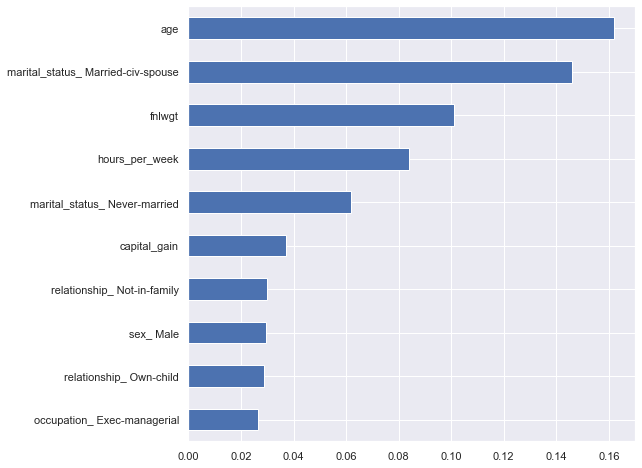

In [ ]:
var_imp.sort_values(by='importance').tail(n=10).plot.barh(figsize=(8,8),
                                               legend=False);

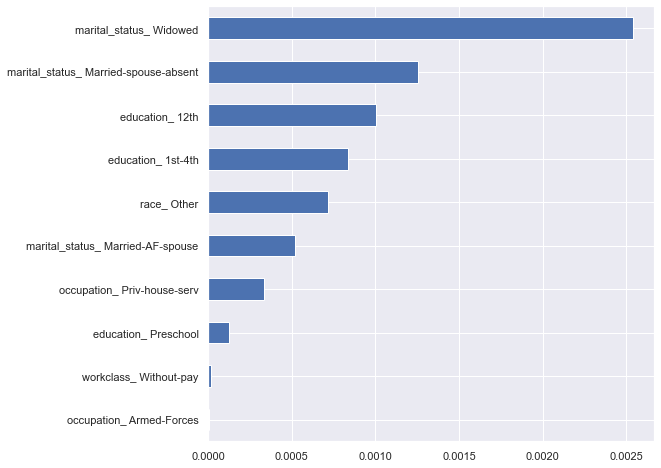

In [ ]:
var_imp.sort_values(by='importance').head(n=10).plot.barh(figsize=(8,8),
                                               legend=False);

## Ensembles

In [ ]:
stacky = StackingClassifier(
    estimators=[('rf', random_forest_CV), ('extratrees', extra_trees_best)],
    final_estimator=GradientBoostingClassifier())

stacky.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(stacky , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['stacky_RF_ET',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced_subsample',
                                                       criterion='entropy',
                                                       max_depth=100,
                                                       min_samples_leaf=2,
                                                       n_estimators=300)),
                               ('extratrees',
                                ExtraTreesClassifier(bootstrap=True,
                                                     class_weight='balanced_subsample',
                                                     criterion='entropy',
                                                     max_depth=50,
                                                     min_samples_leaf=2,
                                                     n_estimators=200))],
                   final_estimator=GradientBoostingClassifier())

,Accuracy,F1 Macro,Precision Macro,Recall Macro
stacky_RF_ET,0.835814,0.765837,0.783876,0.752733


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()

In [ ]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
logreg = LogisticRegression(C=10, penalty='l2', solver='saga', multi_class='multinomial')

In [ ]:
stacky = StackingClassifier(
    estimators=[('rf', random_forest_CV), ('lda', lda_model)],
    final_estimator=GradientBoostingClassifier())

stacky.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(stacky , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['stacky_RF_LDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced_subsample',
                                                       criterion='entropy',
                                                       max_depth=100,
                                                       min_samples_leaf=2,
                                                       n_estimators=300)),
                               ('lda', LinearDiscriminantAnalysis())],
                   final_estimator=GradientBoostingClassifier())

,Accuracy,F1 Macro,Precision Macro,Recall Macro
stacky_RF_LDA,0.838601,0.771236,0.787081,0.75931


In [ ]:
stacky = StackingClassifier(
    estimators=[('rf', random_forest_CV), ('logreg', logreg)],
    final_estimator=GradientBoostingClassifier())

stacky.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(stacky , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

#results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['stacky_RF_logreg',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced_subsample',
                                                       criterion='entropy',
                                                       max_depth=100,
                                                       min_samples_leaf=2,
                                                       n_estimators=300)),
                               ('logreg',
                                LogisticRegression(C=10,
                                                   multi_class='multinomial',
                                                   solver='saga'))],
                   final_estimator=GradientBoostingClassifier())

,Accuracy,F1 Macro,Precision Macro,Recall Macro
stacky_RF_logreg,0.836063,0.76712,0.783663,0.754954


In [ ]:

voting_best = VotingClassifier([('rf', random_forest_CV),
                                ('extratrees', extra_trees_best)],voting='soft')
voting_best.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(voting_best , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

#results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['voting_soft_RF_ET',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     criterion='entropy',
                                                     max_depth=100,
                                                     min_samples_leaf=2,
                                                     n_estimators=300)),
                             ('extratrees',
                              ExtraTreesClassifier(bootstrap=True,
                                                   class_weight='balanced_subsample',
                                                   criterion='entropy',
                                                   max_depth=50,
                                                   min_samples_leaf=2,
                                                   n_estimators=200))],
                 voting='soft')

,Accuracy,F1 Macro,Precision Macro,Recall Macro
stacky_RF_logreg,0.836063,0.76712,0.783663,0.754954
voting_soft_RF_ET,0.814263,0.773379,0.757551,0.807544


In [ ]:

voting_best = VotingClassifier([('rf', random_forest_CV),
                                ('extratrees', extra_trees_best)],voting='hard')
voting_best.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(voting_best , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

#results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['voting_hard_RF_ET',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     criterion='entropy',
                                                     max_depth=100,
                                                     min_samples_leaf=2,
                                                     n_estimators=300)),
                             ('extratrees',
                              ExtraTreesClassifier(bootstrap=True,
                                                   class_weight='balanced_subsample',
                                                   criterion='entropy',
                                                   max_depth=50,
                                                   min_samples_leaf=2,
                                                   n_estimators=200))])

,Accuracy,F1 Macro,Precision Macro,Recall Macro
stacky_RF_logreg,0.836063,0.76712,0.783663,0.754954
voting_soft_RF_ET,0.814263,0.773379,0.757551,0.807544
voting_hard_RF_ET,0.824615,0.77921,0.765469,0.801721


In [ ]:

voting_best = VotingClassifier([('rf', random_forest_CV),
                                ('lda',lda_model)],voting='soft')
voting_best.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(voting_best , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

#results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['voting_soft_RF_LDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     criterion='entropy',
                                                     max_depth=100,
                                                     min_samples_leaf=2,
                                                     n_estimators=300)),
                             ('lda', LinearDiscriminantAnalysis())],
                 voting='soft')

,Accuracy,F1 Macro,Precision Macro,Recall Macro
stacky_RF_logreg,0.836063,0.76712,0.783663,0.754954
voting_soft_RF_ET,0.814263,0.773379,0.757551,0.807544
voting_hard_RF_ET,0.824615,0.77921,0.765469,0.801721
voting_soft_RF_LDA,0.839297,0.780993,0.783768,0.778551


In [ ]:

voting_best = VotingClassifier([('rf', random_forest_CV),
                                ('lda',lda_model)],voting='hard')
voting_best.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(voting_best , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

#results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['voting_hard_RF_LDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     criterion='entropy',
                                                     max_depth=100,
                                                     min_samples_leaf=2,
                                                     n_estimators=300)),
                             ('lda', LinearDiscriminantAnalysis())])

,Accuracy,F1 Macro,Precision Macro,Recall Macro
stacky_RF_logreg,0.836063,0.76712,0.783663,0.754954
voting_soft_RF_ET,0.814263,0.773379,0.757551,0.807544
voting_hard_RF_ET,0.824615,0.77921,0.765469,0.801721
voting_soft_RF_LDA,0.839297,0.780993,0.783768,0.778551
voting_hard_RF_LDA,0.838401,0.762502,0.793275,0.743555


In [ ]:

voting_best = VotingClassifier([('rf', random_forest_CV),
                                ('logreg',logreg)],voting='soft')
voting_best.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(voting_best , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

#results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['voting_soft_RF_logreg',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     criterion='entropy',
                                                     max_depth=100,
                                                     min_samples_leaf=2,
                                                     n_estimators=300)),
                             ('logreg',
                              LogisticRegression(C=10,
                                                 multi_class='multinomial',
                                                 solver='saga'))],
                 voting='soft')

,Accuracy,F1 Macro,Precision Macro,Recall Macro
stacky_RF_logreg,0.836063,0.76712,0.783663,0.754954
voting_soft_RF_ET,0.814263,0.773379,0.757551,0.807544
voting_hard_RF_ET,0.824615,0.77921,0.765469,0.801721
voting_soft_RF_LDA,0.839297,0.780993,0.783768,0.778551
voting_hard_RF_LDA,0.838401,0.762502,0.793275,0.743555
voting_soft_RF_logreg,0.827303,0.739834,0.780062,0.718448


In [ ]:

voting_best = VotingClassifier([('rf', random_forest_CV),
                                ('lda',lda_model)],voting='hard')
voting_best.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(voting_best , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

#results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['voting_hard_RF_logreg',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     criterion='entropy',
                                                     max_depth=100,
                                                     min_samples_leaf=2,
                                                     n_estimators=300)),
                             ('lda', LinearDiscriminantAnalysis())])

,Accuracy,F1 Macro,Precision Macro,Recall Macro
stacky_RF_logreg,0.836063,0.76712,0.783663,0.754954
voting_soft_RF_ET,0.814263,0.773379,0.757551,0.807544
voting_hard_RF_ET,0.824615,0.77921,0.765469,0.801721
voting_soft_RF_LDA,0.839297,0.780993,0.783768,0.778551
voting_hard_RF_LDA,0.838401,0.762502,0.793275,0.743555
voting_soft_RF_logreg,0.827303,0.739834,0.780062,0.718448
voting_hard_RF_logreg,0.838053,0.761852,0.792841,0.742844


## Final model

In [ ]:
voting_best = VotingClassifier([('rf', random_forest_CV),
                                ('lda',lda_model)],voting='soft')
voting_best.fit(X_train, y_train)



cross_val_results = pd.DataFrame(cross_validate(voting_best , X_train, y_train, cv = 10, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_train=pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_train.loc['voting_soft_RF_LDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_train

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     criterion='entropy',
                                                     max_depth=100,
                                                     min_samples_leaf=2,
                                                     n_estimators=300)),
                             ('lda', LinearDiscriminantAnalysis())],
                 voting='soft')

,Accuracy,F1 Macro,Precision Macro,Recall Macro
voting_soft_RF_LDA,0.839596,0.781495,0.784129,0.77916


In [ ]:
y_pred = voting_best.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      7466
           1       0.68      0.67      0.67      2432

    accuracy                           0.84      9898
   macro avg       0.79      0.78      0.78      9898
weighted avg       0.84      0.84      0.84      9898



In [ ]:
confusion(y_test, y_pred)

predicted,0,1
target,,
0,6695,771
1,802,1630
